
# Diseño de software para cómputo científico

----

## Unidad 5: Integración con lenguajes de alto nivel con bajo nivel.


## Agenda de la Unidad 5

- JIT (Numba)
- Cython.
- Integración de Python con FORTRAN.
- **Integración de Python con C.**


## Recapitulando

- Escribimos el código Python.
- Pasamos todo a numpy.
- Hicimos profile.
- Paralelisamos (joblib/dask).
- Hicimos profile.
- Usamos Numba.
- Hicimos profile.
- Si podemos elegir el lenguaje: Cython
    - Si no podemos elegir el lenguaje y vamos a hacer cómputo numérico FORTRAN.
- Si no podemos elegir vamos con C/C++/Rust/lo-que-sea.


## Las consideraciones

In [1]:
# vamos a hacer profiling
import timeit
import math

# vamos a plotear
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

## Numba vs Cython

- Cython es un compilador estático/optimizador tanto para el lenguaje de programación Python como para el extenciones en Cython. 
- Hace que escribir extensiones C para Python sea tan ""fácil"" como el propio Python.
- En lugar de analizar bytecode y generar IR, Cython usa un superconjunto de sintaxis de Python que luego se traduce en código C (Se escribe código C con sintaxis Python).
- A diferencia de usar C, **generalmente** no hay que preocuparse las llamadas de bajo nivel de Python (esto se expande automáticamente a un código C por Cython).
- A diferencia de Numba, todo el código debe estar separado en archivos especiales (`*.pyx`). 
- Cython analiza y traduce dichos archivos a código C y luego lo compila utilizando el compilador C proporcionado.

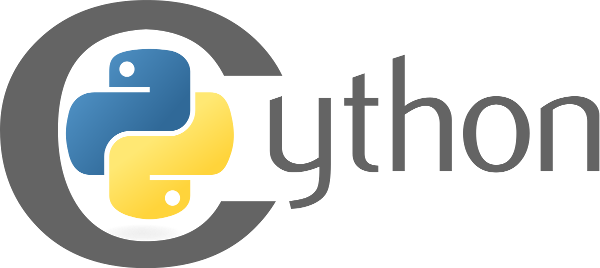

### Por qué preferimos Numba/JIT sobre Cython?

- Curva de aprendizaje (Es otro lenguaje)
- Necesitas *algo* de experiencia en C **Y** Python
- El paquete se vuelve un poco complejo.
- Todo código Python es Cython válido

### Por qué preferimos Cython sobre Numba/C/Fortran?

Facil interaccion con librerias C/C++ y integración total con objetos y clases python

## Ejemplo - Mandelbrot Fractal Python Puro

In [2]:
def mandel(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    i = 0
    c = complex(x,y)
    z = 0.0j
    for i in range(max_iters):
        z = z * z + c
        if (z.real * z.real + z.imag * z.imag) >= 4:
            return i
    return 255

def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x] = color

    return image

## Ejemplo - Mandelbrot Fractal Python Puro

3.99 s ± 37.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


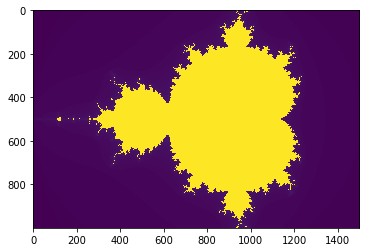

In [3]:
# creamos la imagen
image = np.zeros((500 * 2, 750 * 2), dtype=np.uint8)

# ejecutamos los calculos
normal = %timeit -o create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20)

# mostramos todo
plt.imshow(image, cmap="viridis");

## Ejemplo - Mandelbrot Fractal Cython

In [4]:
%load_ext Cython

In [5]:
%%cython

def mandel(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    i = 0
    c = complex(x,y)
    z = 0.0j
    for i in range(max_iters):
        z = z * z + c
        if (z.real * z.real + z.imag * z.imag) >= 4:
            return i
    return 255

def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x] = color

    return image

## Ejemplo - Mandelbrot Fractal Cython

2.86 s ± 21 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


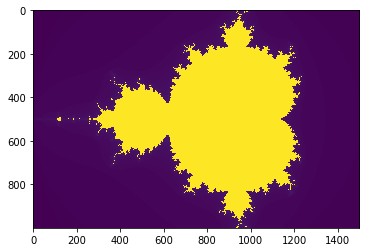

In [6]:
# creamos la imagen
image = np.zeros((500 * 2, 750 * 2), dtype=np.uint8)

# ejecutamos los calculos
normal = %timeit -o create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20)

# mostramos todo
plt.imshow(image, cmap="viridis");

## Cython Hello World 1/2

- Como Cython puede aceptar casi cualquier archivo fuente de Python válido, una de las cosas más difíciles para comenzar es descubrir cómo compilar su extensión.
- Entonces, comencemos con el hola-mundo canónico de Python:

```python 
## helloworld.pyx
print("Hello World")
```

- Pueden ver el código resultante con 
    - `cython -3 helloworld.pyx`,
    - o `cython -3 helloworld.pyx -cplus`

## Cython Hello World 2/2

- Y en `setup.py`

```python
from distutils.core import setup
from Cython.Build import cythonize
setup(
    ...
    ext_modules=cythonize("helloworld.pyx"))
```
- Ejecutar `python setup.py build_ext --inplace`
- Probamos con `python -c "import helloworld"`

In [7]:
import sys
sys.path.insert(0, "./cython")

import helloworld
helloworld.__file__

Hello World


'./cython/helloworld.cpython-37m-x86_64-linux-gnu.so'

## Cython - Números Primos

In [16]:
%%cython
def primes(int nb_primes):
    cdef int n, i, len_p
    cdef int p[1000]  
    if nb_primes > 1000:
        nb_primes = 1000
    len_p = 0  # The current number of elements in p.
    n = 2
    while len_p < nb_primes:
        # Is n prime?
        for i in p[:len_p]:
            if n % i == 0:
                break
        # If no break occurred in the loop, we have a prime.
        else:
            p[len_p] = n
            len_p += 1
        n += 1
    # Let's return the result in a python list:
    result_as_list  = [prime for prime in p[:len_p]]
    return result_as_list

In [17]:
print(primes(100))

[2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97, 101, 103, 107, 109, 113, 127, 131, 137, 139, 149, 151, 157, 163, 167, 173, 179, 181, 191, 193, 197, 199, 211, 223, 227, 229, 233, 239, 241, 251, 257, 263, 269, 271, 277, 281, 283, 293, 307, 311, 313, 317, 331, 337, 347, 349, 353, 359, 367, 373, 379, 383, 389, 397, 401, 409, 419, 421, 431, 433, 439, 443, 449, 457, 461, 463, 467, 479, 487, 491, 499, 503, 509, 521, 523, 541]


## Cython - Números Primos - Numpy

In [18]:
%%cython
import numpy as np # importar donde vas a compilar

def primes_np(int nb_primes):
    
    # Memoryview on a NumPy array
    narr = np.empty(nb_primes, dtype=np.dtype(int))
    cdef long [:] narr_view = narr
    
    len_p = 0  # The current number of elements in p.
    n = 2
    
    while len_p < nb_primes:
        # Is n prime?
        for i in narr_view[:len_p]:
            if n % i == 0:
                break
        # If no break occurred in the loop, we have a prime.
        else:
            narr_view[len_p] = n
            len_p += 1
        n += 1
    return narr

In [20]:
print(primes_np(2000))

[    2     3     5 ... 17383 17387 17389]


## Cython - Números Primos - Profiling


In [21]:
%%cython --annotate
import numpy as np # importar donde vas a compilar

cdef primes_np(unsigned int nb_primes):
    
    # Memoryview on a NumPy array
    narr = np.empty(nb_primes, dtype=np.dtype(int))
    cdef long [:] narr_view = narr
    
    len_p = 0  # The current number of elements in p.
    n = 2
    
    while len_p < nb_primes:
        # Is n prime?
        for i in narr_view[:len_p]:
            if n % i == 0:
                break
        # If no break occurred in the loop, we have a prime.
        else:
            narr_view[len_p] = n
            len_p += 1
        n += 1
    return narr

### Y si usamos la librería vector de C++

In [22]:
%%cython --cplus

from libcpp.vector cimport vector

def primes_cpp(unsigned int nb_primes):
    cdef int n, i
    cdef vector[int] p
    p.reserve(nb_primes)  # allocate memory for 'nb_primes' elements.

    n = 2
    while p.size() < nb_primes:  # size() for vectors is similar to len()
        for i in p:
            if n % i == 0:
                break
        else:
            p.push_back(n)  # push_back is similar to append()
        n += 1

    # Vectors are automatically converted to Python
    # lists when converted to Python objects.
    return p

## Benchmarks

In [23]:
%timeit primes(1000)
%timeit primes_np(1000)
%timeit primes_cpp(1000)

2.03 ms ± 15.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
89.5 ms ± 390 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
2 ms ± 15.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Integrando C puro con Cython

- Supongamos que tenemos ya escrito este super complejo codigo C en un archivo que se llama
  `hello_c.c`.

```C
#include <stdio.h>
void f();

void f() {
    printf("%s", "Hello world from a pure C function!\n");
}
```

Y queremos integrarlo a -Python-

Hay que hacer el wrapper `hello_cwrapper.pyx`.

```cython
cdef extern from "hello_c.c":
    void f()
    
cpdef myf():
    f()
 ```
 
 Despues agregarlo al `setup.py`

## Librería externa desde el notebook

In [24]:
%%cython -I ./cython/

cdef extern from "hello_c.c":
    void f()
    
cpdef myf():
    f()

In [25]:
myf()  ## ESTO IMPRIME SI O SI A LA CONSOLA

## Cosas que quedaron pendientes.

- Structs.
- Enums.
- Classes.
- Memory views.

## Finalizando

- Esto **NO** es más rapido que numpy bien utilizado.
- Copite con numba y el rendimiento es similar.
- En general no es peor que C/C++/FORTRAN.
- Lo mejor es que Python es Válido en Cython.

Y finalmente

**Todo lenguaje que tenga una ABI compatible con C puede interactuar con Cython.**

Osea TODO

## Ctypes

- Permite usar bibliotecas existentes en otros idiomas escribiendo envoltorios **simples** en Python.
- Viene con Python.
- Puede ser un poco **Dificil** de usar.
- Es una herramienta ideal para comper Python

### Ejemplo para Ctypes 1/2

El código C que usaremos en este tutorial está diseñado para ser lo más simple posible mientras demuestra los conceptos que estamos cubriendo. Es más un "ejemplo de juguete" y no pretende ser útil por sí solo. Estas son las funciones que utilizaremos:

```c
int simple_function(void) {
    static int counter = 0;
    counter++;
    return counter;
}
```

- `simple_function` simplemente devuelve números de conteo. 
- Cada vez que se llama en incrementos de contador y devuelve ese valor.

### Ejemplo para Ctypes 2/2

```c
void add_one_to_string(char *input) {
    int ii = 0;
    for (; ii < strlen(input); ii++) {
        input[ii]++;
    }
}
```

- Agrega uno a cada carácter en una matriz de caracteres que se pasa. 
- Usaremos esto para hablar sobre las cadenas inmutables de Python y cómo solucionarlas cuando sea necesario.

Estos ejemplos estan guardadoe en `clibc1.c`, y se compilan con:

```bash
gcc -c -Wall -Werror -fpic clib1.c # crea el código objeto
gcc -shared -o libclib1.so clib1.o # crea el .so
```


## Llamando a una función simple

In [1]:
import ctypes

# Load the shared library into c types.
libc = ctypes.CDLL("ctypes/libclib1.so")

In [6]:
counter = libc.simple_function()
counter

3

## Cadenas inmutables en Python con Ctypes

In [10]:
print("Calling C function which tries to modify Python string")
original_string = "starting string"
print("Before:", original_string)

# This call does not change value, even though it tries!
libc.add_one_to_string(original_string)

print("After: ", original_string)

Calling C function which tries to modify Python string
Before: starting string
After:  starting string


- Como notarán esto **no anda**.
- El `original_string` no está disponible en la función C en absoluto al hacer esto. 
- La función C modificó alguna otra memoria, no la cadena. 
- La función C no solo no hace lo que desea, sino que también modifica la memoria que no debería, lo que genera posibles problemas de corrupción de memoria.
- Si queremos que la función C tenga acceso a la cadena, necesitamos hacer un poco de trabajo de serialización.

## Cadenas inmutables en Python con Ctypes

- Necesitamos convertir la cadena original a bytes usando `str.encode,` y luego pasar esto al constructor para un `ctypes.string_buffer`. 
- Los String_buffers son mutables y se pasan a C como `char *`.

In [11]:
# The ctypes string buffer IS mutable, however.
print("Calling C function with mutable buffer this time")

# Need to encode the original to get bytes for string_buffer
mutable_string = ctypes.create_string_buffer(str.encode(original_string))

print("Before:", mutable_string.value)
libc.add_one_to_string(mutable_string)  # Works!
print("After: ", mutable_string.value)

Calling C function with mutable buffer this time
Before: b'starting string'
After:  b'tubsujoh!tusjoh'


## Especificación de firmas de funciones en ctypes

- Como vimos anteriormente, podemos especificar el tipo de retorno si es necesario.
- Podemos hacer una especificación similar de los parámetros de la función. 
- Además, proporcionar una firma de función le permite a Python verificar que está pasando los parámetros correctos cuando llama a una función C, de lo contrario, pueden suceder cosas **malas**.

Para especificar el tipo de retorno de una función, hayque obtener el bjeto de la función y establecer la propiedad `restype`:

```python
libc.func.restype = ctypes.POINTER(ctypes.c_char)
```

y para especificar las firmas

```python
libc.func.argtypes = [ctypes.POINTER(ctypes.c_char), ]
```

## Referencias

- https://docs.python.org/3.8/library/ctypes.html
- https://dbader.org/blog/python-ctypes-tutorial